# Smoothness analysis with inertial measurement units

This notebooks demonstrates how to use the `quality` package of the ``monalysa`` library to analyse movement smoothness.

Contact siva82kb@gmail.com for any queries.

### Install the most recent monalysa library

In [1]:
import sys
sys.path.append('../../../')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import monalysa
import pandas as pd
from scipy import signal
import glob

In [3]:
from monalysa import movements
from monalysa import quality
from monalysa import readers

In [4]:
import pathlib
from datetime import datetime as dt
from datetime import timedelta as td

### Supporting functions

In [5]:
def group_elems(elms, n): return [elms[i:i+n] for i in range(0, len(elms), n)]

# Read n lines from a file
def read_filelines(fname, n=None):
    with open(fname, 'r') as f:
        return [f.readline() for _ in range(n)] if n else f.readlines()

# Read parse header from OptiTrack CSV file
def read_optitrack_header(fname):
    header = read_filelines(fname, 7)
    _temp = header[0].split("\n")[0].split(",")
    hdr_details = group_elems(_temp, 2)
    # Start time
    _strttime_str = [_hd[1] for _hd in hdr_details if "Start Time" in _hd[0]][0].split(" AM")[0]
    start_time = dt.strptime(_strttime_str, "%Y-%m-%d %H.%M.%S.%f")
    # Sampling rate
    fsamp = [float(_hd[1]) for _hd in hdr_details if "Export Frame Rate" in _hd[0]][0]
    # Column names
    # Top level column names
    lvl1 = [_el.split(":")[1] if ":" in _el else _el
            for _el in header[3].split("\n")[0].split(",")]
    lvl2 = header[6].lower().split("\n")[0].split(",")
    colnames = [list(el) for el in zip(lvl1, lvl2)]
    # Change the first two column names
    colnames[0] = ("frame", "")
    colnames[1] = ("time", "")
    # Shorten level 1 names
    for i in range(2, len(colnames)):
        if colnames[i][0] == "acti":
            colnames[i][0] = "ag"
        if "targ" in colnames[i][0]:
            colnames[i][0] = f"t{colnames[i][0][-1]}"    
    
    return {
        "start_time": start_time,
        "fsamp": fsamp,
        "colnames": colnames,
        "raw": header,
    }

# Read OptiTrack motion capture data
def read_optitrack_data(fname):
    # Read parse header
    header = read_optitrack_header(fname)
    
    # Read marker data.
    mcdata = pd.read_csv(fname, skiprows=7,
                         names=pd.MultiIndex.from_tuples(header['colnames'][1:]),
                         index_col=0)
    return header, mcdata

In [31]:
def compute_velocity(pos: np.array, tsamp: float, twin: float) -> np.array:
    """
    Compute velocity from position data.

    Parameters:
    pos : np.array
        Position data with columns corresponding to different components,
        and rows corresponding to different samples.
    tsamp : float
        Sampling time in seconds.
    twin : float
        Window duration for the Savitsky-Golay (SG) filter used for
        filtering and computing the first derivative of the position data.
        This is used to determine the window length for the SG filter.

    Returns:
    vel : np.array
        Velocity data with columns corresponding to different components,
        and rows corresponding to different samples.
    """
    assert isinstance(pos, np.ndarray), 'pos must be a numpy array.'
    assert twin > tsamp, 'twin must be greater than tsamp.'

    # Filter movements
    _nwin = int(twin / tsamp)
    _nwin += 1 if _nwin % 2 == 0 else 0
    return signal.savgol_filter(pos, _nwin, 1, deriv=1, delta=tsamp,
                                mode='mirror', axis=0)


In [65]:
def get_move_segment_times(vel: np.array, speedth: float, durtol: float) -> np.array:
    """
    Return start and stop indices for different movement segments from velocity data.

    Parameters:
    vel : np.array
        Velocity data with columns corresponding to different components,
        and rows corresponding to different samples.
    speedth : float
        Speed threshold (ratio with respect to maximum speed) for detecting 
        movement segments. Time instants where speed is lower than this 
        threshold multiplied by the max speed are considered rest.
        This should be a number between 0 and 1.
    durtol : float
        Percentage of duration below and after a movement segment to consider for
        identifying movement segments. This value should be between 0 and 1.

    Returns:
    np.array
        An (Nx2) array with start and stop indices for different movement segments.
        The first column corresponds to start times, and the second column corresponds
        to stop times.
    """
    assert isinstance(vel, np.ndarray), 'vel must be a numpy array.'
    assert 0 < speedth < 1, 'speedth must be between 0 and 1.'
    assert 0 < durtol < 1, 'durtol must be between 0 and 1.'

    # Speed
    _spd = np.linalg.norm(vel, axis=1)

    # Movement periods.
    _movseg = _spd > 0.05 * np.max(_spd)

    # Get movement segments
    _strts = np.where(np.diff(np.hstack((0, _movseg))) == 1)[0]
    _stpts = np.where(np.diff(np.hstack((_movseg, 0))) == -1)[0]
    strstpts = np.vstack((_strts, _stpts)).T

    # Adjust start and end points by extending left and right.
    exprcnt = 0.2
    strstpts_adj = []
    for i in range(len(strstpts)):
        _prevstrt = 0 if i == 0 else strstpts[i-1, 0]
        _currstrt = strstpts[i, 0]
        _currstpt = strstpts[i, 1]
        _nextstpt = len(_movseg) - 1 if i == len(strstpts) - 1 else strstpts[i+1, 0]
        _ddur = int(exprcnt * (_currstpt - _currstrt))
        _strt_adj = np.max((_prevstrt, _currstrt - _ddur))
        _stpt_adj = np.min((_currstpt + _ddur, _nextstpt))
        strstpts_adj.append([_strt_adj, _stpt_adj])

    return np.array(strstpts_adj)

---

In [48]:
def convert_to_datetime(dtstr: str):
    try:
        return dt.strptime(dtstr, "%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        return dt.strptime(dtstr, "%Y-%m-%d %H:%M:%S")

In [73]:
# Data directory.
datadir = pathlib.Path("../../../data/ag_data/mocap_ag_expt")

In [74]:
glob.glob(datadir.as_posix() + "/*")

['../../../data/ag_data/mocap_ag_expt/ag_data.csv',
 '../../../data/ag_data/mocap_ag_expt/traingle.csv',
 '../../../data/ag_data/mocap_ag_expt/reaching_via1.csv',
 '../../../data/ag_data/mocap_ag_expt/reaching_via2.csv',
 '../../../data/ag_data/mocap_ag_expt/reaching.csv',
 '../../../data/ag_data/mocap_ag_expt/grasp_object1.csv',
 '../../../data/ag_data/mocap_ag_expt/grasp_object2.csv']

In [75]:
# AG/MOCAP file names.
files2read = {
    "p2preach": "reaching.csv",
    "viareach1": "reaching_via1.csv",
    "viareach2": "reaching_via2.csv",
    "rhythmic": "rhythmic.csv",
    "grasp1": "grasp_object1.csv",
    "grasp2": "grasp_object2.csv"
}

In [156]:
# Read the motion capture data
mc_data = pd.read_csv((datadir / files2read["p2preach"]).as_posix())
mc_data['datetime'] = pd.to_datetime(mc_data['datetime'], format="%Y-%m-%d %H:%M:%S")

# Actigraph maker columsn
agcols = ['actix', 'actiy', 'actiz']

# # Estimate velocity of the AG marker.
t = mc_data['datetime'].values
tsamp = td(microseconds=(t[1] - t[0]).astype(int) / 1000).microseconds / 1000000
fsamp = 1 / tsamp
_pos = mc_data[agcols].values
_vel = compute_velocity(pos=_pos, tsamp=tsamp, twin=0.5)

# Start-stop timestamps
mcstrstpts = get_move_segment_times(vel=_vel, speedth=0.05, durtol=0.2)

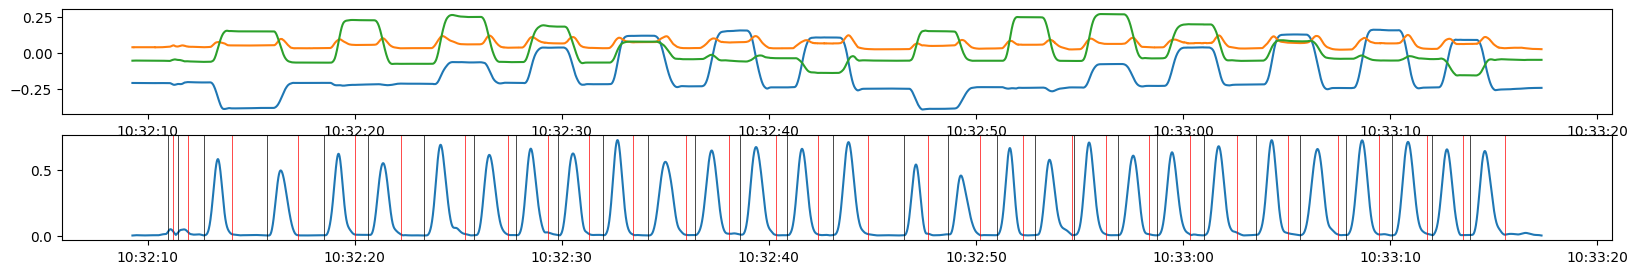

In [157]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(211)
ax.plot(t, _pos)
ax = fig.add_subplot(212)
ax.plot(t, np.linalg.norm(_vel, axis=1))
for i in range(len(mcstrstpts)):
    ax.axvline(t[mcstrstpts[i, 0]], color='k', linewidth=0.5)
    ax.axvline(t[mcstrstpts[i, 1]], color='r', linewidth=0.5)

In [159]:
# Read Actigraph data
ag_data = pd.read_csv((datadir / "ag_data.csv").as_posix())
ag_data['datetime'] = pd.to_datetime(ag_data['datetime'], format="%Y-%m-%d %H:%M:%S")

# Find data with time matching the mocap data.
t_ag = ag_data['datetime'].values


In [160]:
ag_data['datetime'][0]

Timestamp('2023-08-05 10:10:00.010000')

In [161]:
new_mc_data = mc_data.set_index('datetime', inplace=False)
new_mc_data.index

DatetimeIndex(['2023-08-05 10:32:09.260000', '2023-08-05 10:32:09.270000',
               '2023-08-05 10:32:09.280000', '2023-08-05 10:32:09.290000',
               '2023-08-05 10:32:09.300000', '2023-08-05 10:32:09.310000',
               '2023-08-05 10:32:09.320000', '2023-08-05 10:32:09.330000',
               '2023-08-05 10:32:09.340000', '2023-08-05 10:32:09.350000',
               ...
               '2023-08-05 10:33:17.230000', '2023-08-05 10:33:17.240000',
               '2023-08-05 10:33:17.250000', '2023-08-05 10:33:17.260000',
               '2023-08-05 10:33:17.270000', '2023-08-05 10:33:17.280000',
               '2023-08-05 10:33:17.290000', '2023-08-05 10:33:17.300000',
               '2023-08-05 10:33:17.310000', '2023-08-05 10:33:17.320000'],
              dtype='datetime64[ns]', name='datetime', length=6807, freq=None)

In [166]:
mcag_data = mc_data.join(ag_data.set_index('datetime', inplace=False),
                         on='datetime', how='inner', lsuffix='_mc',
                         rsuffix='_ag')

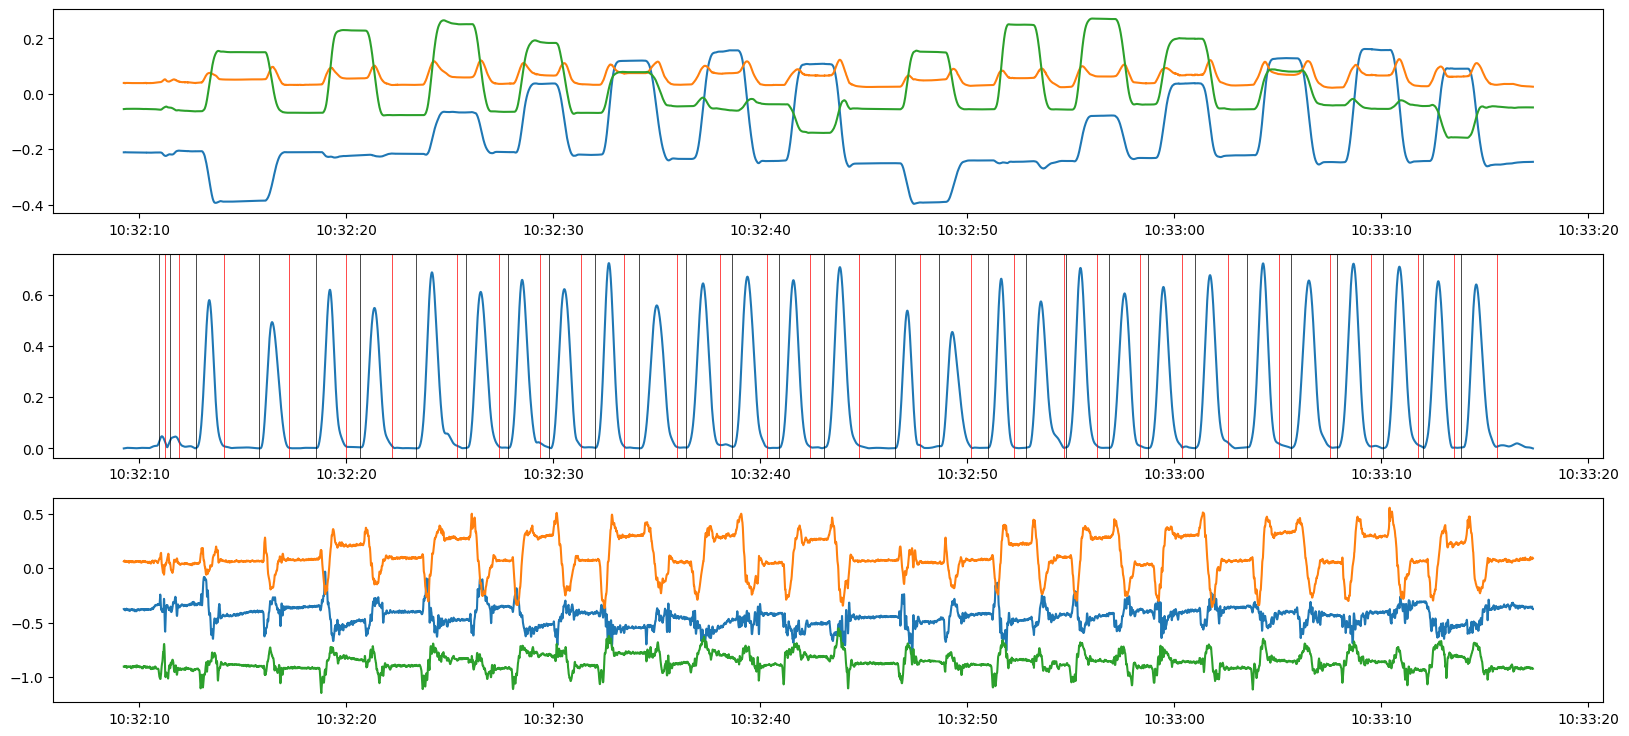

In [168]:
fig = plt.figure(figsize=(20, 9))
ax = fig.add_subplot(311)
ax.plot(t, _pos)
ax = fig.add_subplot(312)
ax.plot(t, np.linalg.norm(_vel, axis=1))
for i in range(len(mcstrstpts)):
    ax.axvline(t[mcstrstpts[i, 0]], color='k', linewidth=0.5)
    ax.axvline(t[mcstrstpts[i, 1]], color='r', linewidth=0.5)
ax = fig.add_subplot(313)
ax.plot(t, mcag_data['actix_ag'])
ax.plot(t, mcag_data['actiy_ag'])
ax.plot(t, mcag_data['actiz_ag'])

In [92]:
mc_data.set_index('datetime', inplace=True)

In [93]:
mc_data

,actix,actiy,actiz,targ1x,targ1y,targ1z,targ2x,targ2y,targ2z,targ3x,...,targ4z,targ5x,targ5y,targ5z,targ6x,targ6y,targ6z,targ7x,targ7y,targ7z
datetime,,,,,,,,,,,,,,,,,,,,,
2023-08-05 10:32:09.260000,-0.211088,0.039047,-0.055135,0.241382,0.003082,-0.262046,0.317053,0.001953,-0.143143,0.303201,...,0.220045,0.086172,-0.002608,0.337526,-0.112864,-0.005495,0.364618,-0.261853,-0.004827,0.286578
2023-08-05 10:32:09.270000,-0.211103,0.039049,-0.055037,0.241349,0.003115,-0.261986,0.317042,0.001945,-0.143151,0.303217,...,0.220036,0.086065,-0.002073,0.337270,-0.112868,-0.005501,0.364632,-0.261801,-0.004850,0.286606
2023-08-05 10:32:09.280000,-0.211186,0.039600,-0.054885,0.241312,0.003168,-0.261973,0.317048,0.001918,-0.143139,0.303207,...,0.220073,0.086076,-0.002058,0.337267,-0.112868,-0.005500,0.364638,-0.261820,-0.004859,0.286617
2023-08-05 10:32:09.290000,-0.211041,0.039121,-0.054871,0.241378,0.003098,-0.262053,0.317057,0.001936,-0.143161,0.303201,...,0.220051,0.086072,-0.002058,0.337270,-0.112871,-0.005517,0.364628,-0.261866,-0.004847,0.286584
2023-08-05 10:32:09.300000,-0.211052,0.039088,-0.054767,0.241357,0.003198,-0.262059,0.317061,0.001928,-0.143142,0.303194,...,0.220056,0.086064,-0.002059,0.337266,-0.112874,-0.005505,0.364640,-0.261825,-0.004859,0.286609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-05 10:33:17.280000,-0.245537,0.025717,-0.049204,0.241395,0.002998,-0.262068,0.317068,0.001884,-0.143137,0.303222,...,0.220052,0.086073,-0.002078,0.337277,-0.112883,-0.005531,0.364638,-0.261793,-0.004829,0.286470
2023-08-05 10:33:17.290000,-0.245494,0.025689,-0.049182,0.241407,0.002988,-0.262077,0.317074,0.001863,-0.143135,0.303219,...,0.220056,0.086064,-0.002080,0.337280,-0.112886,-0.005516,0.364629,-0.261852,-0.004824,0.286522
2023-08-05 10:33:17.300000,-0.245456,0.025633,-0.049168,0.241408,0.002989,-0.262081,0.317074,0.001836,-0.143143,0.303215,...,0.220079,0.086071,-0.002088,0.337286,-0.112869,-0.005512,0.364631,-0.261786,-0.004793,0.286469


In [91]:
ag_data

,actix,actiy,actiz,datetime
0,0.0,0.0,0.0,2023-08-05 10:10:00.010000
1,0.0,0.0,0.0,2023-08-05 10:10:00.020000
2,0.0,0.0,0.0,2023-08-05 10:10:00.030000
3,0.0,0.0,0.0,2023-08-05 10:10:00.040000
4,0.0,0.0,0.0,2023-08-05 10:10:00.050000
...,...,...,...,...
321013,0.0,0.0,0.0,2023-08-05 11:03:30.140000
321014,0.0,0.0,0.0,2023-08-05 11:03:30.150000
321015,0.0,0.0,0.0,2023-08-05 11:03:30.160000
321016,0.0,0.0,0.0,2023-08-05 11:03:30.170000


In [87]:
(t_ag[1] - t_ag[0]).microseconds

10000

In [71]:
# Read the AG data
ag_data = pd.read_csv((ag_datadir / files2read["p2preach"]).as_posix(), header=5)
ag_data

,Frame,Time (Seconds),X,Y,Z,X.1,Y.1,Z.1,X.2,Y.2,...,Z.4,X.5,Y.5,Z.5,X.6,Y.6,Z.6,X.7,Y.7,Z.7
0,0,0.00,-0.211088,0.039047,-0.055135,0.241382,0.003082,-0.262046,0.317053,0.001953,...,0.220045,0.086172,-0.002608,0.337526,-0.112864,-0.005495,0.364618,-0.261853,-0.004827,0.286578
1,1,0.01,-0.211103,0.039049,-0.055037,0.241349,0.003115,-0.261986,0.317042,0.001945,...,0.220036,0.086065,-0.002073,0.337270,-0.112868,-0.005501,0.364632,-0.261801,-0.004850,0.286606
2,2,0.02,-0.211186,0.039600,-0.054885,0.241312,0.003168,-0.261973,0.317048,0.001918,...,0.220073,0.086076,-0.002058,0.337267,-0.112868,-0.005500,0.364638,-0.261820,-0.004859,0.286617
3,3,0.03,-0.211041,0.039121,-0.054871,0.241378,0.003098,-0.262053,0.317057,0.001936,...,0.220051,0.086072,-0.002058,0.337270,-0.112871,-0.005517,0.364628,-0.261866,-0.004847,0.286584
4,4,0.04,-0.211052,0.039088,-0.054767,0.241357,0.003198,-0.262059,0.317061,0.001928,...,0.220056,0.086064,-0.002059,0.337266,-0.112874,-0.005505,0.364640,-0.261825,-0.004859,0.286609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,6802,68.02,-0.245537,0.025717,-0.049204,0.241395,0.002998,-0.262068,0.317068,0.001884,...,0.220052,0.086073,-0.002078,0.337277,-0.112883,-0.005531,0.364638,-0.261793,-0.004829,0.286470
6803,6803,68.03,-0.245494,0.025689,-0.049182,0.241407,0.002988,-0.262077,0.317074,0.001863,...,0.220056,0.086064,-0.002080,0.337280,-0.112886,-0.005516,0.364629,-0.261852,-0.004824,0.286522
6804,6804,68.04,-0.245456,0.025633,-0.049168,0.241408,0.002989,-0.262081,0.317074,0.001836,...,0.220079,0.086071,-0.002088,0.337286,-0.112869,-0.005512,0.364631,-0.261786,-0.004793,0.286469
6805,6805,68.05,-0.245430,0.025580,-0.049171,0.241425,0.002989,-0.262087,0.317075,0.001882,...,0.220099,0.086073,-0.002074,0.337282,-0.112871,-0.005508,0.364628,-0.261783,-0.004803,0.286472


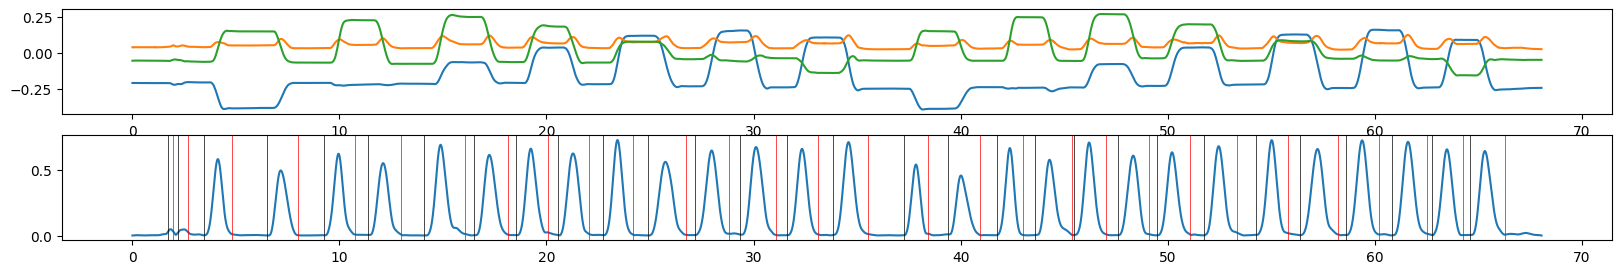

In [16]:
# Point to point reaching movement.
fname = mc_datadir / files2read["p2preach"]

# Read Optitrack data.
mcheader, mcdata = read_optitrack_data(fname)
mctimestamps = [mcheader['start_time'] + td(seconds=_t) for _t in mcdata['time']]

# Estimate velocity of the AG marker.
_t = mcdata[("time", "")].values
_pos = mcdata["ag"].values
_vel = compute_velocity(pos=_pos, tsamp=1/mcheader["fsamp"], twin=0.5)

# Start-stop timestamps
mcstrstpts = get_move_segment_times(vel=_vel, speedth=0.05, durtol=0.2)

fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(211)
ax.plot(_t, _pos)
ax = fig.add_subplot(212)
ax.plot(_t, np.linalg.norm(_vel, axis=1))
for i in range(len(mcstrstpts)):
    ax.axvline(_t[mcstrstpts[i, 0]], color='k', linewidth=0.5)
    ax.axvline(_t[mcstrstpts[i, 1]], color='r', linewidth=0.5)

In [17]:
# Get the movement segments.
selected_segs = np.diff(mcstrstpts, axis=1).flatten() > 100
vel_segs = [np.linalg.norm(_vel[_s1:_s2+1, :], axis=1)
            for _sel, (_s1, _s2) in zip(selected_segs, mcstrstpts)
            if _sel]

# Get the timestamps
mc_seg_ts = [[mctimestamps[_s1], mctimestamps[_s2]]
             for _sel, (_s1, _s2) in zip(selected_segs, mcstrstpts)
             if _sel]

In [18]:
# Read ActiGraph data
agfile = ag_datadir / "monalysa_rec (2023-08-05)RAW.csv"
agdata = readers.ActiGraphData(filename=agfile, devid="ag")

agdata

ActiGraphData(filename='../../../data/actigraph_raw_data/monalysa_rec (2023-08-05)RAW.csv', id='ag')

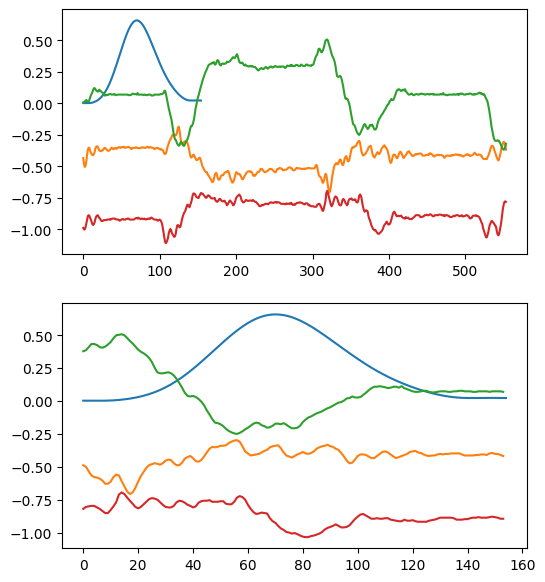

In [61]:
i = 6
fig = plt.figure(figsize=(6, 7))
ax = fig.add_subplot(211)
ax.plot(vel_segs[i])
_tsinx = ((agdata.data['TimeStamp'] >= mc_seg_ts[i][0] - td(seconds=2)) &
          (agdata.data['TimeStamp'] <= mc_seg_ts[i][1] + td(seconds=2)))
ax.plot(agdata.data.loc[_tsinx, ['AcclX', 'AcclY', 'AcclZ']].values)
ax = fig.add_subplot(212)
ax.plot(vel_segs[i])
_tsinx = ((agdata.data['TimeStamp'] >= mc_seg_ts[i][0] + td(seconds=1.05)) &
          (agdata.data['TimeStamp'] <= mc_seg_ts[i][1] + td(seconds=1.05)))
ax.plot(agdata.data.loc[_tsinx, ['AcclX', 'AcclY', 'AcclZ']].values)

In [29]:
mc_seg_ts[i][0] + td(seconds=1.7)

datetime.datetime(2023, 8, 5, 10, 32, 42, 578000)

In [27]:
vel_segs

[array([0.00146331, 0.00188511, 0.00219748, 0.0026697 , 0.00305426,
        0.00353312, 0.00412893, 0.00490251, 0.00586977, 0.00725112,
        0.00870161, 0.01046103, 0.01249544, 0.01502915, 0.01791047,
        0.02117153, 0.02484966, 0.02883751, 0.03335762, 0.03860116,
        0.04419598, 0.05055352, 0.05748511, 0.06482777, 0.07261083,
        0.08120329, 0.09044437, 0.1003412 , 0.11090267, 0.12211675,
        0.13395273, 0.14640902, 0.15945445, 0.17309088, 0.1872627 ,
        0.20193976, 0.21711989, 0.23273977, 0.24876807, 0.2651357 ,
        0.28179949, 0.29872557, 0.31585075, 0.33307323, 0.3503164 ,
        0.36777165, 0.38505876, 0.40190667, 0.4185344 , 0.43474775,
        0.4504616 , 0.46562244, 0.48017795, 0.49393497, 0.50699026,
        0.51909097, 0.53023884, 0.54037791, 0.54945508, 0.55743162,
        0.56435174, 0.57000221, 0.57442541, 0.57756581, 0.57941611,
        0.57985966, 0.57889881, 0.57653199, 0.57272346, 0.56759438,
        0.56129167, 0.55370547, 0.54505965, 0.53

In [25]:
agdata.data.loc[_tsinx, 'TimeStamp'].values

array(['2023-08-05T10:32:40.880000000', '2023-08-05T10:32:40.890000000',
       '2023-08-05T10:32:40.900000000', '2023-08-05T10:32:40.910000000',
       '2023-08-05T10:32:40.920000000', '2023-08-05T10:32:40.930000000',
       '2023-08-05T10:32:40.940000000', '2023-08-05T10:32:40.950000000',
       '2023-08-05T10:32:40.960000000', '2023-08-05T10:32:40.970000000',
       '2023-08-05T10:32:40.980000000', '2023-08-05T10:32:40.990000000',
       '2023-08-05T10:32:41.000000000', '2023-08-05T10:32:41.010000000',
       '2023-08-05T10:32:41.020000000', '2023-08-05T10:32:41.030000000',
       '2023-08-05T10:32:41.040000000', '2023-08-05T10:32:41.050000000',
       '2023-08-05T10:32:41.060000000', '2023-08-05T10:32:41.070000000',
       '2023-08-05T10:32:41.080000000', '2023-08-05T10:32:41.090000000',
       '2023-08-05T10:32:41.100000000', '2023-08-05T10:32:41.110000000',
       '2023-08-05T10:32:41.120000000', '2023-08-05T10:32:41.130000000',
       '2023-08-05T10:32:41.140000000', '2023-08-05

In [23]:
agdata.data

,AcclX,AcclY,AcclZ,TimeStamp
0,0.809,-0.117,0.125,2023-08-05 10:10:00.000
1,0.789,-0.117,0.113,2023-08-05 10:10:00.010
2,0.824,-0.117,0.082,2023-08-05 10:10:00.020
3,0.875,-0.148,0.102,2023-08-05 10:10:00.030
4,0.949,-0.195,0.133,2023-08-05 10:10:00.040
...,...,...,...,...
320895,0.000,0.000,0.000,2023-08-05 11:03:28.950
320896,0.000,0.000,0.000,2023-08-05 11:03:28.960
320897,0.000,0.000,0.000,2023-08-05 11:03:28.970
320898,0.000,0.000,0.000,2023-08-05 11:03:28.980


In [74]:
mcheader['start_time']

datetime.datetime(2023, 8, 5, 10, 32, 9, 248000)

In [76]:
agdata.data.loc[0, 'TimeStamp']

Timestamp('2023-08-05 10:10:00')